## corv: A Tutorial

[GitHub Page](https://github.com/vedantchandra/corv)

---

1. [Fitting A DA White Dwarf Without Templates](#da-no-template)
2. [Fitting A DB White Dwarf Without Templates](#db-no-template)

The role of this notebook is to present $\texttt{corv}$. $\texttt{corv}$ determines radial velocities using two methods. First,  

<a id="da-no-template"></a>

**01. Fitting A DA White Dwarf Without Templates (Need to check/proofread)**

---

The following is an example using $\texttt{corv}$ to calculate radial velocities of DA white dwarfs. It does this by isolating a portion of the spectrum around each absorption line. Then, $\texttt{corv}$ generates a model. When fitting without templates, that model consists of the control parameters of each Voigt profile plus a parameter for radial velocity. Then, $\texttt{corv}$ fits each parameter.

In [1]:
import corv
from astroquery.sdss import SDSS
import matplotlib.pyplot as plt

could not find pickled WD models
using local paths
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


We use astroquery to get an example spectrum. This is a good DA white dwarf.

In [2]:
plate = 3650
mjd = 55244
fiberid = 485

spec = SDSS.get_spectra_async(plate=plate, fiberID=fiberid, mjd=mjd)[0].get_fits()

In [3]:
i = 1

wl = 10**spec[i].data['loglam']
fl = spec[i].data['flux']
ivar = spec[i].data['ivar']

Text(0.5, 1.0, 'White Dwarf Spectrum')

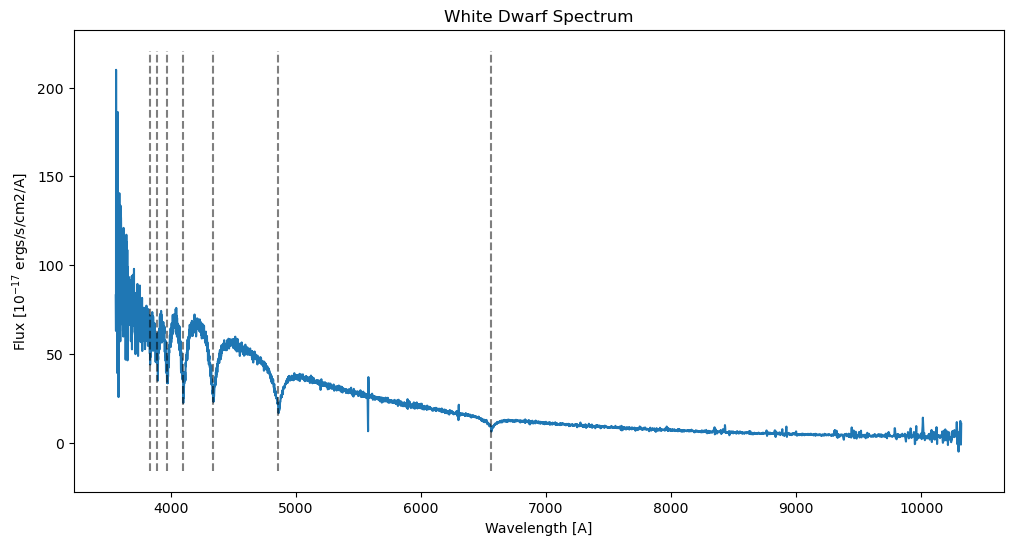

In [4]:
balmer_lines = [6562.79, 4861.35, 4340.47, 4101.73, 3970.07, 3889.06, 3835.40]

plt.figure(figsize=(12,6))

plt.plot(wl, fl)
min_, max_ = plt.ylim()
plt.vlines(balmer_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)
plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
plt.xlabel(r'Wavelength [A]')
plt.title('White Dwarf Spectrum')

Now we have the information we need to calculate the RV of this object. We do this by first creating a model and then fitting the model. This can be done in two lines:

`
corvmodel = corv.models.make_balmer_model(nvoigt = 2, names = ['a','b','g','d'])
`

This is the line that creates the model. `nvoigt = 2` tells $\texttt{corv}$ to fit each absorption line using 2 voigt profiles, and `names = ['a', 'b', 'g', 'd']` tells $\texttt{corv}$ to fit radial velocity using the Balmer $\alpha$, $\beta$, $\gamma$, and $\delta$ lines.

`
param_res, rv_res, rv_init = corv.fit.fit_corv(wl, fl, ivar, corvmodel)
`

Next, we fit the model we've created. $\texttt{corv}$ takes wavelength, flux, and ivar as arguments as well as the model. It returns two $\texttt{lmfit}$ objects: `param_res` and `rv_res`, and a float: `rv_init`. $\texttt{corv}$ works in two steps of fitting. First, all parameters are fitted at the same time. These results are returned in `param_res`. Second, every variable except radial velocity is frozen at the values given in `param_res`, and a second round of fitting is performed where only radial velocity is allowed to vary. The final fitted radial velocity is the one given in `rv_res`. `rv_init` is the first guess radial velocity in km/s.

In short: if you want to use $\texttt{corv}$ radial velocities, use the radial velocity from `rv_res`.

In [5]:
corvmodel = corv.models.make_balmer_model(nvoigt = 2, names = ['a','b','g','d'])

param_res, rv_res, rv_init = corv.fit.fit_corv(wl, fl, ivar, corvmodel)

starting...


NotImplementedError: emcee version 3 is required.

One of $\texttt{corv}$'s utility functions allows us to see how good of a fit we've made. This is the `lineplot` function:

`
corv.utils.lineplot(wl, fl, ivar, corvmodel, rv_res.params, printparams = False, gap = 0.3, figsize = (6, 5))
`

The first three inputs allow plotting of the raw data. `corvmodel` and `rv_res.params` tell $\texttt{corv}$ what model and what parameters for that model to use.

In [ ]:
corv.utils.lineplot(wl, fl, ivar, corvmodel, rv_res.params, printparams = False, gap = 0.3, figsize = (6, 5))

In [ ]:
rv_res.params['RV']

<a id="db-no-template"></a>

**02. Fitting A DB White Dwarf Without Templates (Need to check/proofread)**

---

In [ ]:
from astroquery.simbad import Simbad

# Astropy
from astropy import coordinates as coord
from astropy import units as u
from astropy.table import Table

result_table = Simbad.query_bibobj('2015A&A...583A..86K')

print(result_table)

In [ ]:
from astroquery.vo_conesearch import conf, conesearch, vos_catalog

result_table['coords'] = [coord.SkyCoord(result_table['RA'][i], result_table['DEC'][i], unit=(u.hourangle, u.deg), frame = 'icrs') for i in range(len(result_table))]


In [ ]:
'''
Gautham: I'm trying to find a good DB spectrum. They're saved in the spec/ folder, what do you think of #101?



from tqdm import tqdm

for i in tqdm(range(100, 500)):
    try:
        xid = SDSS.query_region(result_table['coords'][i], radius='5 arcsec', spectro=True)
        
        xid['plate']
        
        plate = xid['plate'][0]
        mjd = xid['mjd'][0]
        fiber = xid['fiberID'][0]
        
        
        #print(plate, mjd, fiber)
        
        k = 1
        
        spec = SDSS.get_spectra_async(plate=plate, fiberID=fiberid, mjd=mjd)[0].get_fits()
        
        wl = 10**spec[k].data['loglam']
        fl = spec[k].data['flux']
        ivar = spec[k].data['ivar']
        
        he_lines = [5047.74, 5875.6404]
        
        plt.figure(figsize=(12,6))
            
        plt.plot(wl, fl)
        min_, max_ = plt.ylim()
        plt.vlines(he_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)
        plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
        plt.xlabel(r'Wavelength [A]')
        plt.title(i)
        
        plt.savefig('spec/image{}.png'.format(i))
        plt.close()
    except:
        pass
'''